# NSSP project 1
### confirmatory analysis - ICA

In this notebook, we aims to study the neural processing of emotionally provocative auditory stimuli.

# Setup the notebook

### Import, setup FSL

In [5]:
%gui wx
import sys
import os
import os.path as op

#utility functions from previous labs
import utils 

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

import matplotlib.pyplot as plt
import numpy as np

import nilearn 
from nilearn.decomposition import CanICA
from nilearn.plotting import plot_prob_atlas,plot_stat_map, show
from nilearn.image import iter_img, mean_img

from pathlib import Path

from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
from nilearn.image import iter_img
from sklearn.decomposition import FastICA, PCA

from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

In [2]:
#We define the parameters RERUN to rerun all the transform, if false it will use the saved files.
RERUN = False

In [7]:
####################
# Setup FSL path
####################
utils.loadFSL()
################
# Start FSLeyes 
################
fsleyesDisplay = utils.FSLeyesServer()
fsleyesDisplay.show()

19:38:25: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:38:25: Debug: Adding duplicate animation handler for '1' type
19:38:25: Debug: Adding duplicate animation handler for '2' type
19:38:25: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:38:25: Debug: Adding duplicate animation handler for '1' type
19:38:25: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:21832): Gtk-CRITICAL **: 19:38:25.896: gtk_window_resize: assertion 'height > 0' failed
19:38:27: Debug: ScreenToClient cannot work when toplevel window is not shown
19:38:27: Debug: ScreenToClient cannot work when toplevel window is not shown
19:38:27: Debug: ScreenToClient cannot work when toplevel window is not shown
19:38:27: Debug: ScreenToClient cannot work when toplevel window is not shown
19:38:27: Debug: ScreenToClient cannot work when toplevel window is not shown
19:38:27: Debug: ScreenToClient cannot work when toplevel window is not shown
19:38:27: De

# Loading FMRI data

In [3]:
dataset= 'ds000171'
version = '00001'
subject = 'sub-control01'
subjectID = 'control01'
sample_path = "dataset"

# Construct paths
bids_root = os.path.join(os.path.abspath(""), sample_path, dataset)
deriv_root = os.path.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

data_concat = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold.nii'.format(subjectID))
data_motion_corrected = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco.nii.gz'.format(subjectID))
data_smoothed = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_smoothed-6mm.nii.gz'.format(subjectID))

In [23]:
data = nib.load(data_smoothed).get_fdata()
print(data.shape)
x,y,z,nvol = data.shape

(80, 80, 50, 315)


In [9]:
# fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(data_smoothed)

In [15]:
#https://nilearn.github.io/dev/connectivity/resting_state_networks.html#fitting-canica-model-with-nilearn
#https://nilearn.github.io/dev/modules/generated/nilearn.decomposition.CanICA.html
#https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_compare_decomposition.html#sphx-glr-auto-examples-03-connectivity-plot-compare-decomposition-py

# APPLY ICA

In [27]:
X = data.reshape(-1, nvol)
print(X.shape)
X = np.nan_to_num(X,0) # nan to 0s

(320000, 315)


In [30]:
nComps = 3

## use ICA on the SPATIAL axis
icas = FastICA(n_components=nComps)
icasig_space = icas.fit_transform(X)

## use ICA on the TEMPORAL axis
icat = FastICA(n_components=nComps) 
icasig_time = icat.fit_transform(X.T)  

## Then reshape spatial sources into 2D images
C = np.empty([nComps, x, y, z])
for i in range(nComps):
    C[i]=np.reshape(icasig_space[:,i],[x,y,z])
    
print("The shape of C is :", C.shape)

The shape of C is : (3, 80, 80, 50)


# other method

## Applying ICA

In [22]:
canica = CanICA(
    n_components=3,
    verbose=1,
    memory = None,
    mask_strategy="epi",
    n_init = 10,
    random_state=0,
    standardize="zscore_sample"
)
canica.fit(data_motion_corrected)

# Retrieve the independent components in brain space.
canica_components_img = canica.components_img_
# components_img is a Nifti Image object, and can be saved to a file with
# the following lines:
output_dir = Path.cwd() / "results" / "plot_compare_decomposition"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")
canica_components_img.to_filename(output_dir / "canica_resting_state.nii.gz")

[MultiNiftiMasker.fit] Loading data from [/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco.nii.gz].
[{self.__class__.__name__}.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
Output will be saved to: /data/results/plot_compare_decomposition


## ICA result

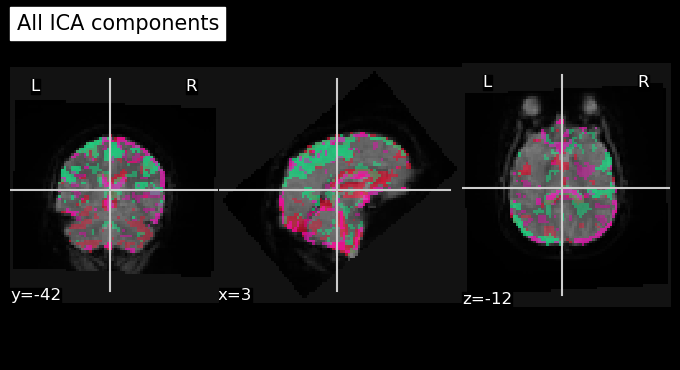

In [23]:
# Plot all ICA components together
plot_prob_atlas(canica_components_img, bg_img = mean_img(data_motion_corrected),title="All ICA components")

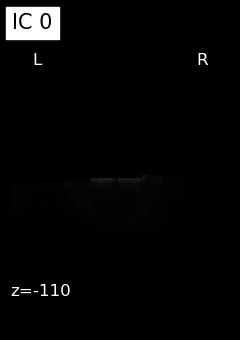

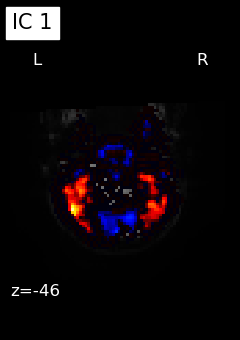

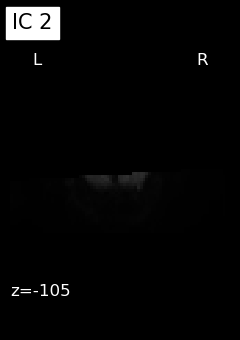


(ipykernel_launcher.py:5579): Gdk-WARNING **: 10:16:36.783: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [24]:
for i, cur_img in enumerate(iter_img(canica_components_img)):
    plot_stat_map(
        cur_img,
        bg_img = mean_img(data_motion_corrected),
        display_mode="z",
        title=f"IC {int(i)}",
        cut_coords=1,
        colorbar=False,
    )